# Finetune EfficientNet-B7


## efficientnetb7_1080repetitive


With 1920x1080 repetitive-padded melspectrogram images without data augmentation


In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import random

In [2]:
# Get the absolute path to the project root without relying on __file__
notebook_path = os.getcwd()  # Gets current working directory
project_root = os.path.abspath(os.path.join(notebook_path, "../../.."))
sys.path.insert(0, project_root)

In [3]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu121
True


Set the seed for reproducability


In [4]:
random_seed = 42

torch.manual_seed(random_seed)
np.random.seed(random_seed)
random.seed(random_seed)

if (torch.cuda.is_available()):
    torch.cuda.manual_seed(random_seed)

Set some constant strings


In [5]:
model_name = 'efficientnetb7_1080repetitive'

train_csv = '../../../data/melspectrogram_train_dataset.csv'
test_csv = '../../../data/melspectrogram_test_dataset.csv'
val_csv = '../../../data/melspectrogram_val_dataset.csv'
root_dir = '../../../data/'
class_weights_path = '../../../data/class_weights.pt'

Import other helper classes


In [6]:
from cnn.datasets.MelspectrogramDataset import MelSpectrogramDataset
from cnn.pipeline.Pipeline import Pipeline

Define the model


In [7]:
model = models.efficientnet_b7(pretrained=True)

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\myenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B7_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B7_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Prepare for fine-tuning


In [8]:
# Number of classes
num_classes = 9

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Modify final fully connected layer according to number of classes
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Unfreeze the last 3 layers so that they can be fine-tuned
# Adjust the indices based on the actual number of layers in model.features
for idx in [-3, -2, -1]:  # Use negative indices to target the last 3 layers
    for param in model.features[idx].parameters():
        param.requires_grad = True

# Replace classifier
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, num_classes)

# Unfreeze classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
            (1): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

Define the learning rate, criterion, optimizer, transformations, and number of epochs


In [9]:
learning_rate = 0.001

class_weights = torch.load(class_weights_path).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define transformations
transform = transforms.Compose([
    # Resize the Mel spectrogram to 600x600, suitable for EfficientNet-B7
    transforms.Resize((600, 600)),
    transforms.ToTensor(),          # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[
                         0.229, 0.224, 0.225])  # Normalize to ImageNet stats
])

num_epochs = 50

C:\Users\profi\AppData\Local\Temp\ipykernel_9460\1571873306.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  class_weights = torch.load(class_weights_path).to(device)


Prepare datasets and dataloaders


In [10]:
trainset = MelSpectrogramDataset(
    csv_file=train_csv, root_dir=root_dir, transform=transform)
valset = MelSpectrogramDataset(
    csv_file=val_csv, root_dir=root_dir, transform=transform)
testset = MelSpectrogramDataset(
    csv_file=test_csv, root_dir=root_dir, transform=transform)

trainloader = DataLoader(trainset, batch_size=8,
                         shuffle=True, num_workers=8, pin_memory=True)
valloader = DataLoader(valset, batch_size=8,
                       shuffle=False, num_workers=8, pin_memory=True)
testloader = DataLoader(testset, batch_size=8,
                        shuffle=False, num_workers=8, pin_memory=True)

Execute the pipeline


Mapping from Emotion to Number: {'Anger': 0, 'Bored': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Question': 6, 'Sad': 7, 'Surprise': 8}
Model is on: cuda:0
Epoch 1/50


Validating: 100%|██████████| 1185/1185 [02:40<00:00,  7.36it/s, Loss=0.3022274076938629, Elapsed=171.9076s, ETA=0.0000s]  


Epoch 1 completed in 1343.8970s
Train Loss: 1.0623316969372083 - Train Accuracy: 58.14432057167409
Validation Loss: 0.8250760344324736 - Validation Accuracy: 69.19586323343184

Epoch 2/50


Validating: 100%|██████████| 1185/1185 [02:40<00:00,  7.37it/s, Loss=0.16408562660217285, Elapsed=172.0119s, ETA=0.0000s] 


Epoch 2 completed in 1345.3973s
Train Loss: 0.7767323260067514 - Train Accuracy: 69.49865448542548
Validation Loss: 0.704103861111786 - Validation Accuracy: 75.16884761502743

Epoch 3/50


Validating: 100%|██████████| 1185/1185 [02:40<00:00,  7.37it/s, Loss=0.02005867473781109, Elapsed=172.1816s, ETA=0.0000s]  


Epoch 3 completed in 1345.3242s
Train Loss: 0.6542463109443738 - Train Accuracy: 74.28144998982384
Validation Loss: 0.6754002344402591 - Validation Accuracy: 74.2929506120726

Epoch 4/50


Validating: 100%|██████████| 1185/1185 [02:40<00:00,  7.37it/s, Loss=0.18401864171028137, Elapsed=171.9759s, ETA=0.0000s]  


Epoch 4 completed in 1344.9220s
Train Loss: 0.5649923228022916 - Train Accuracy: 77.96974288234097
Validation Loss: 0.6583476640755617 - Validation Accuracy: 78.85183621781341

Epoch 5/50


Validating: 100%|██████████| 1185/1185 [02:40<00:00,  7.36it/s, Loss=0.44680705666542053, Elapsed=172.2068s, ETA=0.0000s]  


Epoch 5 completed in 1346.5686s
Train Loss: 0.49290540895865176 - Train Accuracy: 80.73087447140499
Validation Loss: 0.6519873732708803 - Validation Accuracy: 77.9864921907978

Epoch 6/50


Validating: 100%|██████████| 1185/1185 [02:40<00:00,  7.37it/s, Loss=0.04104423522949219, Elapsed=172.1569s, ETA=0.0000s]  


Epoch 6 completed in 1346.4609s
Train Loss: 0.4167482083777148 - Train Accuracy: 83.51914248886276
Validation Loss: 0.6610594055018062 - Validation Accuracy: 75.88644997889405

EarlyStopping counter: 1/5
Epoch 7/50


Validating: 100%|██████████| 1185/1185 [02:40<00:00,  7.37it/s, Loss=0.00261385808698833, Elapsed=172.2746s, ETA=0.0000s]   


Epoch 7 completed in 1346.3668s
Train Loss: 0.3630095237555463 - Train Accuracy: 85.25361253702992
Validation Loss: 0.7456150881346818 - Validation Accuracy: 78.89404812157028

EarlyStopping counter: 2/5
Epoch 8/50


Validating: 100%|██████████| 1185/1185 [02:40<00:00,  7.37it/s, Loss=0.0036647978704422712, Elapsed=172.0914s, ETA=0.0000s] 


Epoch 8 completed in 1346.5409s
Train Loss: 0.30769582700583487 - Train Accuracy: 87.27301508333144
Validation Loss: 0.853471929935261 - Validation Accuracy: 78.17644575770368

EarlyStopping counter: 3/5
Epoch 9/50


Validating: 100%|██████████| 1185/1185 [02:40<00:00,  7.40it/s, Loss=0.004205385223031044, Elapsed=171.1090s, ETA=0.0000s]  


Epoch 9 completed in 1341.8075s
Train Loss: 0.26965103875449914 - Train Accuracy: 88.84466656113611
Validation Loss: 0.8997541729822274 - Validation Accuracy: 77.80709159983115

EarlyStopping counter: 4/5
Epoch 10/50


Validating: 100%|██████████| 1185/1185 [02:39<00:00,  7.41it/s, Loss=0.0013990061124786735, Elapsed=170.7950s, ETA=0.0000s] 

Epoch 10 completed in 1338.3722s
Train Loss: 0.2399531980594364 - Train Accuracy: 89.91429411365641
Validation Loss: 0.9609508784736585 - Validation Accuracy: 77.74377374419586

EarlyStopping counter: 5/5
🔁 Early stopping triggered!


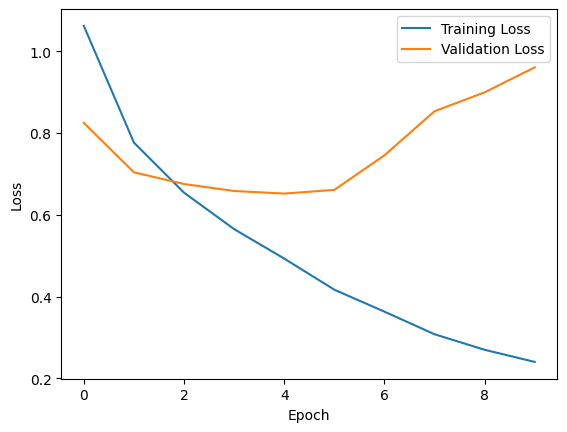

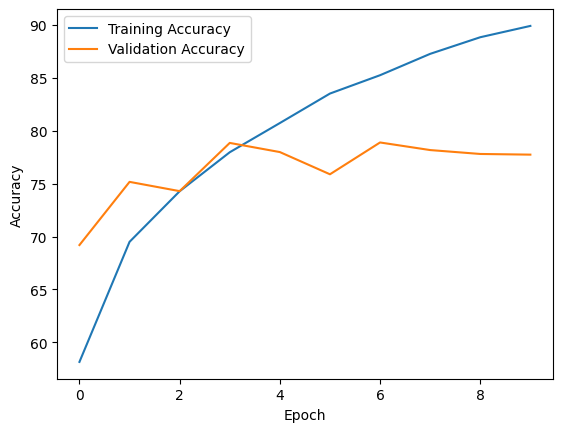

c:\Users\profi\OneDrive\Desktop\AI-Project--Speech-Emotion-Recognition\cnn\pipeline\Pipeline.py:217: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torc

Evaluating best model on test set...


Testing: 100%|██████████| 1185/1185 [02:50<00:00,  6.95it/s]

Test Accuracy: 0.7808
Test Precision: 0.7955
Test Recall: 0.7808
Test F1-score: 0.7837

              precision    recall  f1-score   support

       Anger       0.78      0.80      0.79       916
       Bored       0.80      0.94      0.86      1098
     Disgust       0.62      0.58      0.60       291
        Fear       0.39      0.73      0.50       308
       Happy       0.87      0.70      0.78      1914
     Neutral       0.75      0.76      0.75      2226
    Question       0.92      0.92      0.92      1139
         Sad       0.82      0.71      0.76       857
    Surprise       0.80      0.77      0.79       728

    accuracy                           0.78      9477
   macro avg       0.75      0.77      0.75      9477
weighted avg       0.80      0.78      0.78      9477



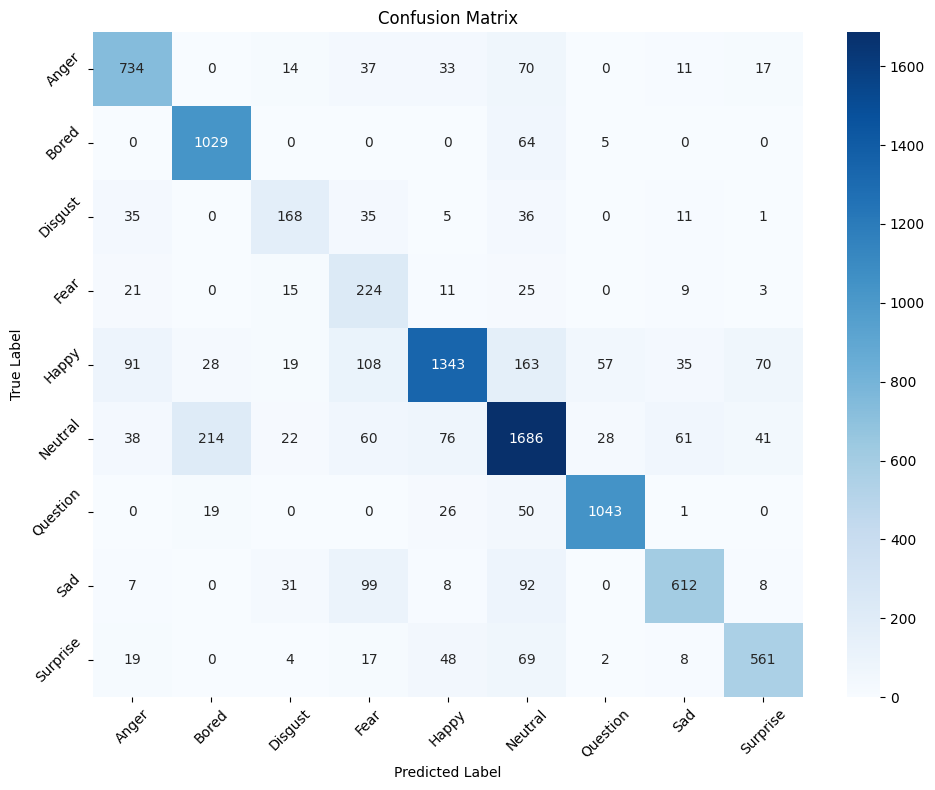

In [11]:
Pipeline.execute(
    model=model,
    labelmap=trainset.label_map,
    trainloader=trainloader,
    valloader=valloader,
    testloader=testloader,
    criterion=criterion,
    optimizer=optimizer,
    device=device,
    num_epochs=num_epochs,
    model_name=model_name,
    patience=5
)